## Sentinel-2 Median Mosaic Notebook

This notebook creates a median mosaic using Sentinel-2 data. A median mosaic is a mathematical median of the spectral band values for a time series of images. In most cases it is best to create a time window surrounding a desired date to allow the introduction of scenes with minimal cloud cover. Once a median calculation is applied, the resulting mosaic is often cloud-free and suitable for further analyses. This notebook will demonstrate the review of time series data, the application of cloud filtering, and the generation and view of a median mosaic image. The final image will be written to a GeoTIFF output file for further analyses.

The baseline data is [Sentinel-2 Level-2A](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a) data from the MS Planetary Computer catalog.

In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio
from matplotlib.cm import RdYlGn,jet,RdBu

# Import Planetary Computer tools
import pystac_client
import planetary_computer as pc
import odc
from odc.stac import stac_load

### Load the satellite data

First, we define our area of interest using latitude and longitude coordinates of the corners. Then we define a bounding box and time window to search the archive for data. GeoJSON format uses a specific order: (longitude, latitude), so be careful when entering the coordinates. 

In [2]:
# Define the corners of a bounding box for the region (Latitude, Longitude)
# This is a region in Rio de Janeiro, Brazil

lower_left = (-23.05, -43.54)
upper_right = (-22.81, -43.15)
bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])

In [3]:
# Define the time window
# This time window surrounds the date of ground-based UHI data collection in Brazil: 23-Jan-2023

time_window = "2022-12-01/2023-04-01"

Using the `pystac_client` we can search the Planetary Computer's STAC catalog for items matching our query parameters. The result is the number of scenes matching our search criteria that touch our area of interest. Some of these may be partial scenes and may contain clouds. To avoid scenes with large amounts of clouds, we will limit our scenes to 30% overall cloud cover.

In [4]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    collections=["sentinel-2-l2a"], 
    bbox=bounds, 
    datetime=time_window,
    query={"eo:cloud_cover": {"lt": 30}},
)

items = list(search.get_all_items())
print('This is the number of scenes that touch our region:',len(items))

This is the number of scenes that touch our region: 12


Next, we'll load the data into an [xarray](https://xarray.pydata.org/en/stable/) DataArray using the Open Data Cube (ODC) STAC [odc-stac](https://odc-stac.readthedocs.io/en/latest/index.html) library that is included with the Planetary Computer. The [ODC](https://www.opendatacube.org) is an open source geospatial data management and analysis software project that is used globally for many projects (e.g., Digital Earth Africa). The ODC-STAC code will load the selected items from the catalog search, select the desired spectral bands (including the SCL cloud filtering band), reproject into Lat-Lon coordinates (EPSG:4326) at 10-meters resolution (typical of Sentinel-2 pixel resolution), and clip the region to the spatial bounding box. 

In [5]:
# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees

resolution = 10  # meters per pixel 
scale = resolution / 111320.0 # degrees per pixel for CRS:4326 

### Sentinel-2 Bands Summary 
The following list of common bands can be loaded by the Open Data Cube (ODC) stac command.<br><br>
B01 = Coastal Aerosol = 60m <br>
B02 = Blue = 10m <br>
B03 = Green = 10m <br>
B04 = Red = 10m <br>
B05 = Red Edge (704 nm) = 20m <br>
B06 = Red Edge (740 nm) = 20m <br>
B07 = Red Edge (780 nm) = 20m <br>
B08 = NIR (833 nm) = 10m <br>
B8A = NIR (narrow 864 nm) = 20m <br>
B09 = Water Vapour (945 nm) = 60m <br>
B11 = SWIR (1.6 um) = 20m <br>
B12 = SWIR (2.2 um) = 20m <br>
SCL = Scene Classifier = 20m

In [6]:
data = stac_load(
    items,
    bands=["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B11", "B12", "SCL"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=pc.sign,
    bbox=bounds
)

In [7]:
# View the dimensions of our XARRAY (in pixels) and the variables
display(data)

<xarray.Dataset> Size: 3GB
Dimensions:      (latitude: 2673, longitude: 4343, time: 9)
Coordinates:
  * latitude     (latitude) float64 21kB -22.81 -22.81 -22.81 ... -23.05 -23.05
  * longitude    (longitude) float64 35kB -43.54 -43.54 -43.54 ... -43.15 -43.15
  * time         (time) datetime64[ns] 72B 2022-12-09T13:02:51.024000 ... 202...
    spatial_ref  int32 4B 4326
Data variables: (12/13)
    B01          (time, latitude, longitude) uint16 209MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B02          (time, latitude, longitude) uint16 209MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B03          (time, latitude, longitude) uint16 209MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B04          (time, latitude, longitude) uint16 209MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B05          (time, latitude, longitude) uint16 209MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B06          (time, latitude, longitude) uint16 209MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    ...           ...
    B08          (time, latitude, longitude) uint16 209MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B8A          (time, latitude, longitude) uint16 209MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B09          (time, latitude, longitude) uint16 209MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B11          (time, latitude, longitude) uint16 209MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B12          (time, latitude, longitude) uint16 209MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    SCL          (time, latitude, longitude) uint16 209MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>

### View RGB (real color) images from the time series

Data is available for Sentinel-2 from 2016 to now. Since this mission includes two satellites, it is possible to view any location on the ground every 5 days. But, not all locations are planned for 5-day revisits (two satellites) but all locations have at least 10-day revisits (one satellite). Also, due to extreme cloud cover, some scenes are not even processed. So, when viewing a time series you might see large gaps in time due to coverage choices or cloud contamination. When viewing the scenes (see below) it is easy to identify the clouds as regions of "bright white". Overall, the presence of clouds makes the use of optical data very challenging.

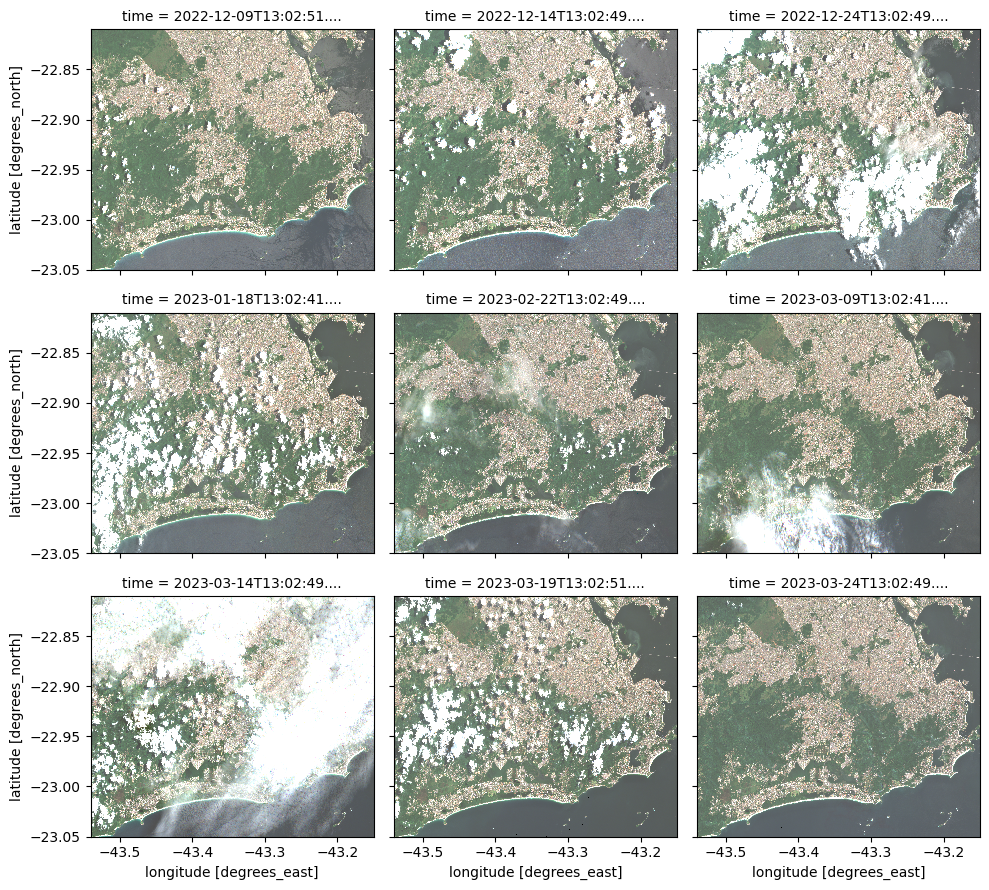

In [10]:
plot_data = data[["B04","B03","B02"]].to_array()
plot_data.plot.imshow(col='time', col_wrap=3, robust=True, vmin=0, vmax=3000)
plt.show()

In [11]:
# Select a time slice to view a single RGB image and the cloud mask
# See the XARRAY dimensions above for the number of time slices 
# The numbering starts at 0

time_slice = 1

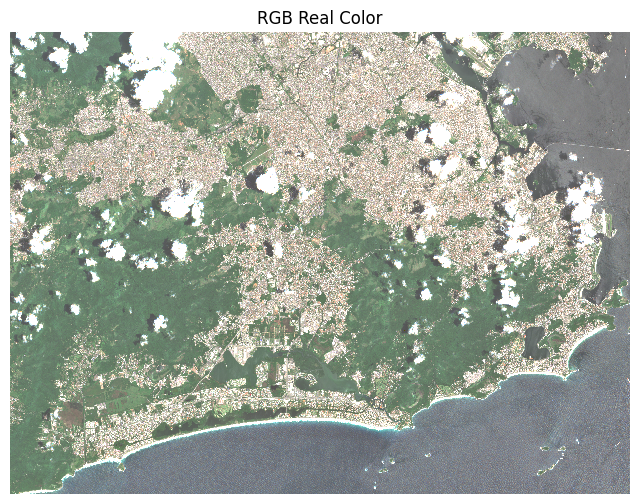

In [12]:
# Plot and RGB Real Color Image for a single date (larger view)
fig, ax = plt.subplots(figsize=(8,6))
data.isel(time=time_slice)[["B04","B03","B02"]].to_array().plot.imshow(robust=True, ax=ax, vmin=0, vmax=3000)
ax.set_title("RGB Real Color")
ax.axis('off')
plt.show()

### Apply Cloud Filtering and Masking

In [13]:
# Filter data using the Sentinel-2 SCL band classification

# scl=0 > No Data
# scl=1 > Saturated
# scl=3 > Cloud Shadows
# scl=6 > Water 
# scl=8 > Cloud Medium Probability 
# scl=9 > Cloud High Probability
# scl=10 > Thin Cirrus Cloud

In [14]:
# Create a colormap to display the SCL pixel classifications

scl_colormap = np.array(
    [
        [252,  40, 228, 255],  # 0  - NODATA - MAGENTA
        [255,   0,   4, 255],  # 1  - Saturated or Defective - RED
        [0  ,   0,   0, 255],  # 2  - Dark Areas - BLACK
        [97 ,  97,  97, 255],  # 3  - Cloud Shadow - DARK GREY
        [3  , 139,  80, 255],  # 4  - Vegetation - GREEN
        [192, 132,  12, 255],  # 5  - Bare Ground - BROWN
        [21 , 103, 141, 255],  # 6  - Water - BLUE
        [117,   0,  27, 255],  # 7  - Unclassified - MAROON
        [208, 208, 208, 255],  # 8  - Cloud - LIGHT GREY
        [244, 244, 244, 255],  # 9  - Definitely Cloud - WHITE
        [195, 231, 240, 255],  # 10 - Thin Cloud - LIGHT BLUE
        [222, 157, 204, 255],  # 11 - Snow or Ice - PINK
    ],
    dtype="uint8",
)

In [15]:
def colorize(xx, colormap):
    return xr.DataArray(colormap[xx.data], coords=xx.coords, dims=(*xx.dims, "band"))

In [16]:
# Load SCL band, then convert to RGB using color scheme above
scl_rgba = colorize(data.isel(time=time_slice).SCL.compute(), scl_colormap)

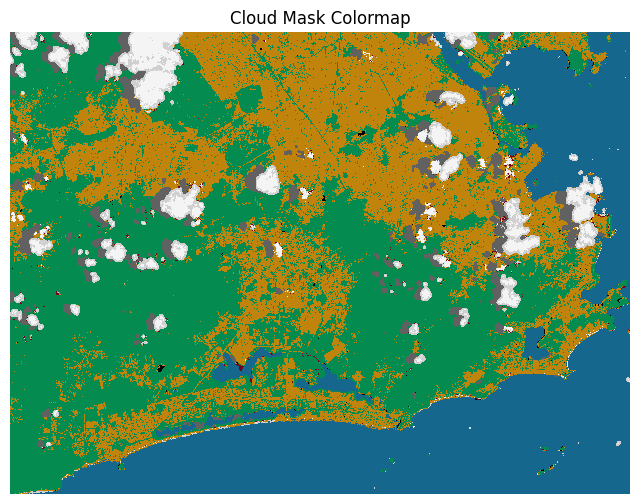

In [17]:
# Create an RGB plot of the SCL band
# Notice the clouds are bright white and the cloud shadows are grey

scl_rgba.plot.imshow(size=6)
plt.title("Cloud Mask Colormap")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.axis('off')
plt.show()

In [18]:
# Create a mask for no data, saturated data, clouds, and cloud shadows

cloud_mask = \
    (data.SCL != 0) & \
    (data.SCL != 1) & \
    (data.SCL != 3) & \
    (data.SCL != 8) & \
    (data.SCL != 9) & \
    (data.SCL != 10) 

In [19]:
# Apply cloud mask ... NO Clouds, NO Cloud Shadows
cleaned_data = data.where(cloud_mask).astype("uint16")

In [20]:
# Load SCL band, then convert to RGB using color scheme above
scl_rgba_clean = colorize(cleaned_data.isel(time=time_slice).SCL.compute(), scl_colormap)

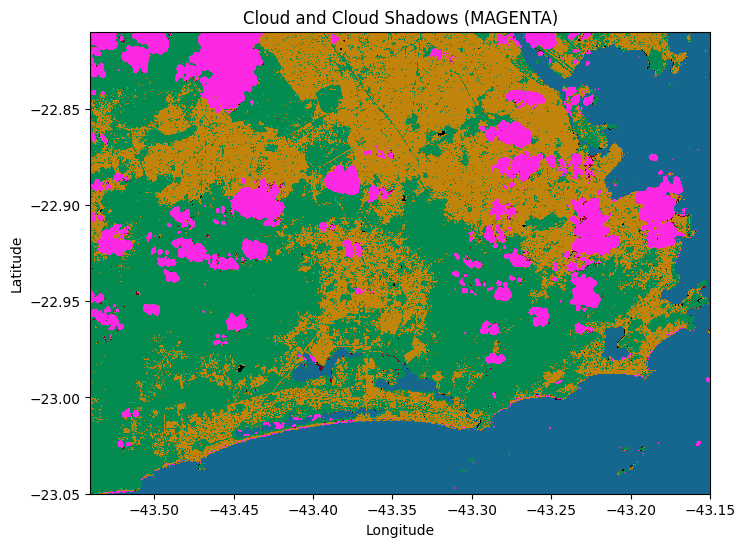

In [21]:
# Create an RGB plot of the SCL band
# Masked data (clouds/shadows) are shown in MAGENTA

scl_rgba_clean.plot.imshow(size=6)
plt.title("Cloud and Cloud Shadows (MAGENTA)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

### Median composite

Using normal xarray operations, we can compute a statistical median over the time dimension. Under the assumption that clouds are not common (<30% per scene) and in random locations, the composite shouldn't contain (many) clouds, since they shouldn't be the median pixel value at that point over many images. This process is commonly used to "filter" clouds and create synthetic images that are mostly free of cloud contamination.

In [22]:
median = data.median(dim="time").compute()

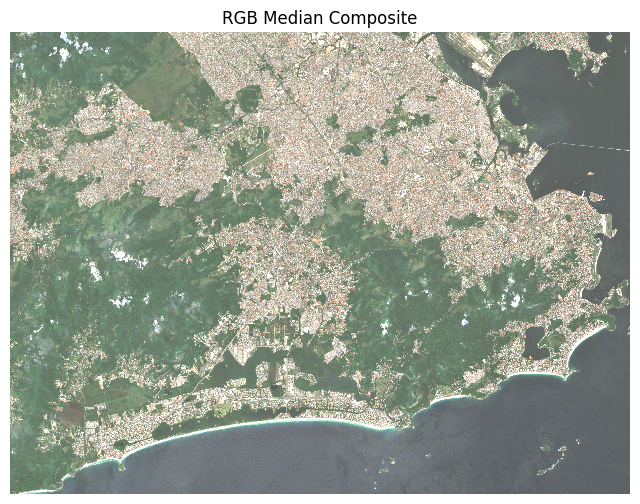

In [23]:
# Plot an RGB image for the median composite or mosaic
# Notice how this new image is void of clouds due to statistical filtering

fig, ax = plt.subplots(figsize=(8,6))
median[["B04", "B03", "B02"]].to_array().plot.imshow(robust=True, ax=ax, vmin=0, vmax=3000)
ax.set_title("RGB Median Composite")
ax.axis('off')
plt.show()

The <b>Normalized Difference Vegetation Index (NDVI)</b> is used to measure the "greenness" of vegetation and has a range of 0.0 to 1.0. Low values (0.0 to 0.25) reflect a lack of vegetation (bare soil, urban, water), middle values (0.25 to 0.6) reflect grasslands or croplands in their growing state, and high values (0.6 to 1.0) reflect dense vegetation such as trees or croplands at their peak vegetation state. Such information can be relevant to modeling urban heating as the proximity to vegetation or "green space" can mitigate urban heating. The equation uses two spectral bands where: <b>NDVI = (NIR-Red) / (NIR+Red).

In [24]:
# Calculate NDVI for the median mosaic
ndvi_median = (median.B08-median.B04)/(median.B08+median.B04)

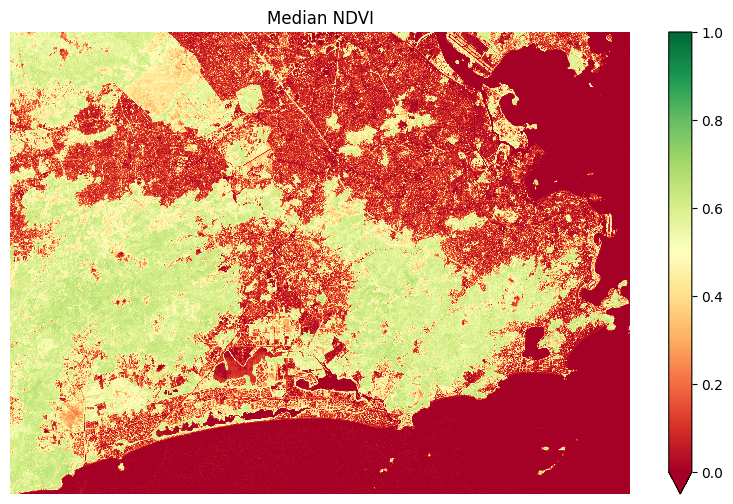

In [25]:
fig, ax = plt.subplots(figsize=(10,6))
ndvi_median.plot.imshow(vmin=0.0, vmax=1.0, cmap="RdYlGn")
plt.title("Median NDVI")
plt.axis('off')
plt.show()

The <b>Normalized Difference Buildup Index (NDBI)</b> is a ratio-based index that uses the Near Infra-red (NIR) and shortwave-infrared (SWIR) band (1.6 um, Band-11) to highlight built-up areas or areas of urbanization. Low values (below zero) reflect a lack of urbanization and are typical of water or vegetation. High values (above zero) reflect urbanization with the highest densities where the colors are dark red. Such information can be relevant to modeling urban heating as urban density and increase urban heating. The equation uses two spectral bands where: <b>NDBI = (SWIR-NIR) / (SWIR+NIR).

In [26]:
# Calculate NDBI for the median mosaic
ndbi_median = (median.B11-median.B08)/(median.B11+median.B08)

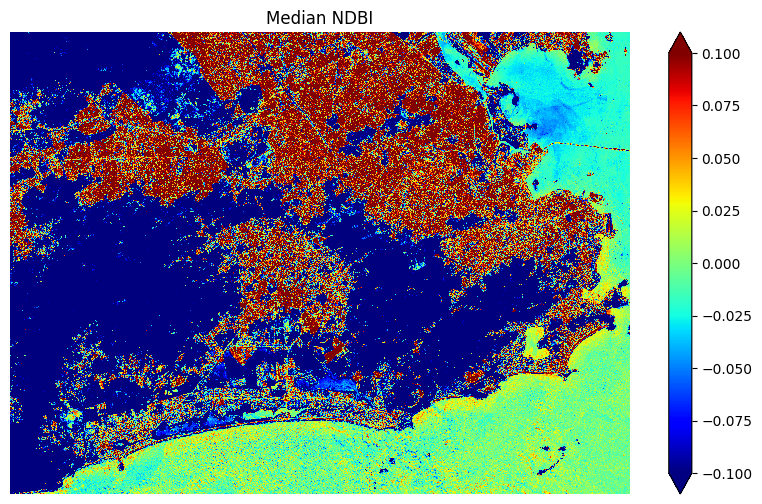

In [27]:
fig, ax = plt.subplots(figsize=(10,6))
ndbi_median.plot.imshow(vmin=-0.1, vmax=0.1, cmap="jet")
plt.title("Median NDBI")
plt.axis('off')
plt.show()

The <b>Normalized Difference Water Index (NDWI)</b> is a ratio-based index that uses the Green and Near Infra-Red (NIR) band to highlight areas with surface water. The scale below is set up to highlight areas of water (above zero) in BLUE and areas of non-water (below zero) in RED. Such information can be relevant to modeling urban heating as the proximity to water can mitigate urban heating. The equation uses two spectral bands where: <b>NDWI = (GREEN-NIR) / (GREEN+NIR).

In [28]:
# Calculate NDWI for the median mosaic
ndwi_median = (median.B03-median.B08)/(median.B03+median.B08)

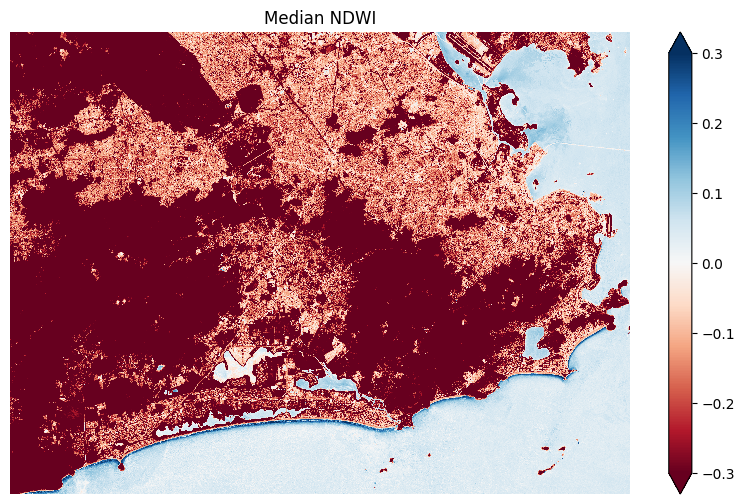

In [29]:
fig, ax = plt.subplots(figsize=(10,6))
ndwi_median.plot.imshow(vmin=-0.3, vmax=0.3, cmap="RdBu")
plt.title("Median NDWI")
plt.axis('off')
plt.show()

### Save the output data in a GeoTIFF file
Using the median mosaic, we will create a GeoTIFF output product that includes all of the spectral bands and the three index productrs (NDVI, NDBI, NDWI). 

In [30]:
filename = "S2_median_Brazil.tiff"

In [31]:
# Calculate the dimensions of the file
height = median.dims["latitude"]
width = median.dims["longitude"]

In [32]:
# Define the Coordinate Reference System (CRS) to be common Lat-Lon coordinates
# Define the tranformation using our bounding box so the Lat-Lon information is written to the GeoTIFF
gt = rasterio.transform.from_bounds(lower_left[1],lower_left[0],upper_right[1],upper_right[0],width,height)
median.rio.write_crs("epsg:4326", inplace=True)
median.rio.write_transform(transform=gt, inplace=True);

In [33]:
# Create the GeoTIFF output file using the defined parameters 
with rasterio.open(filename,'w',driver='GTiff',width=width,height=height,
                   crs='epsg:4326',transform=gt,count=15,compress='lzw',dtype='float64') as dst:
    dst.write(median.B01,1)
    dst.write(median.B02,2)
    dst.write(median.B03,3) 
    dst.write(median.B04,4)
    dst.write(median.B05,5)
    dst.write(median.B06,6)
    dst.write(median.B07,7) 
    dst.write(median.B08,8)
    dst.write(median.B8A,9)
    dst.write(median.B09,10)
    dst.write(median.B11,11) 
    dst.write(median.B12,12)
    dst.write(ndvi_median,13)
    dst.write(ndbi_median,14)
    dst.write(ndwi_median,15)
    dst.close()

In [34]:
# Show the location of the new output file
!ls *.tiff

S2_median_Brazil.tiff
